# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone https://github.com/Renass/cvr_course

fatal: destination path 'cvr_course' already exists and is not an empty directory.


In [2]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


# Finding contour of a paper    
low_th, high_th - min and max intensivity to find white pixels and create mask

Afted finding contours we choose the one with max area and make it convex

epsilon - parameter of making poligonal model of contour

We need to find corner dots of paper so we need a 4-sides polygon

In [3]:
from random import randrange
import numpy as np

def find_contour (img,low_th,high_th,show_mask=False,show_frame=False,show=False):
    mask = cv2.inRange (img, low_th, high_th)
    if show_mask==True:
      plt.imshow(mask)
      plt.show()

    contours, hierarchy = cv2.findContours (mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
    max_area=0
    for contour in contours: 
      if show_frame==True: 
        color = (randrange(255), randrange(255), randrange(255))  
        borders=cv2.drawContours(img, contour, -1, color, 10)
      area = cv2.contourArea(contour)
      if area> max_area:
        max_area=area
        cnt=contour
    if show_frame==True:
      plt.imshow(img)
      plt.show()  
    
    
   
    approx = cv2.convexHull (cnt)
    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    if show==True:
      borders=cv2.drawContours(img, approx, -1, (255,0,0), 30)
      plt.imshow(borders)
      plt.show()
    return approx



def find_distance (img,contour):
    length = cv2.arcLength (contour, True)
    distance = 180.0 * 364 / length
    return distance


def order_points(pts,show=False):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=2)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    pts=np.delete(pts,np.argmax(s),axis=0)
    s = pts.sum(axis=2)
    pts=np.delete(pts,np.argmin(s),axis=0)
    s = pts.sum(axis=2)
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=2)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]


    if show==True:   
      font = cv2.FONT_HERSHEY_SIMPLEX
      text1=cv2.putText(img,"1",org=(rect[0][0],rect[0][1]),fontFace=font,color=(255,0,0),fontScale=1,thickness=3)
      text2=cv2.putText(img,"2",org=(rect[1][0],rect[1][1]),fontFace=font,color=(255,0,0),fontScale=1,thickness=3)
      text3=cv2.putText(img,"3",org=(rect[2][0],rect[2][1]),fontFace=font,color=(255,0,0),fontScale=1,thickness=3)
      text4=cv2.putText(img,"4",org=(rect[3][0],rect[3][1]),fontFace=font,color=(255,0,0),fontScale=1,thickness=3)
      plt.imshow(text1)
      plt.show()
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts,show=False):
    # obtain a consistent order of the points and unpack them
    # individually
    (tl, tr, br, bl) = pts
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    if show==True:
      plt.imshow(warped)
      plt.show()
    # return the warped image
    return warped
def crop(img,x,y,show=False):
  crop=img[y[0]:y[1],x[0]:x[1]]
  if show==True:
    plt.imshow(crop)
    plt.show()
  return crop

distance from camera to paper is 88.91905392477372


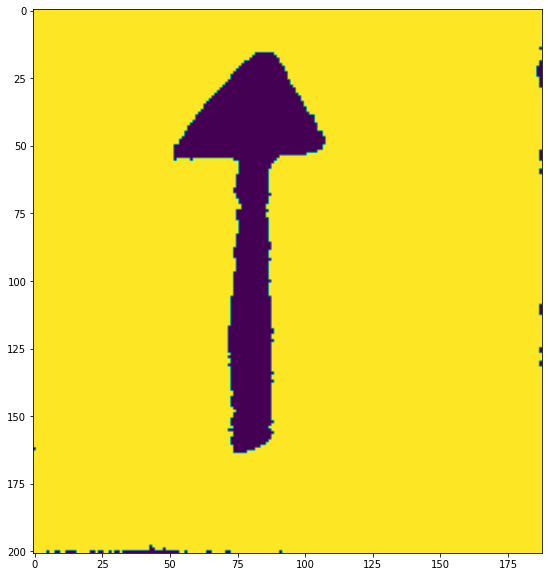

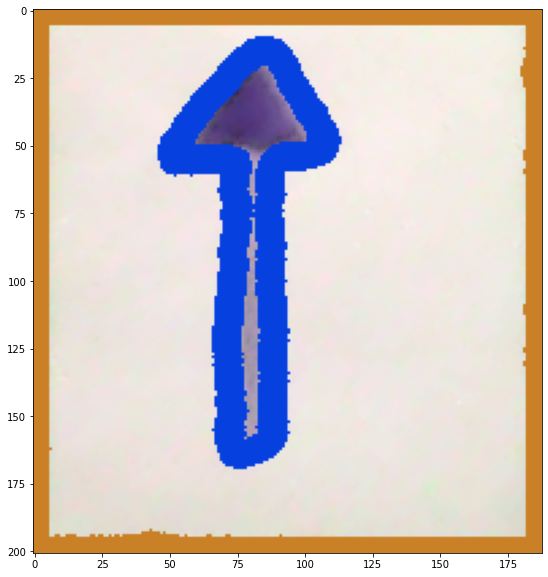

distance from camera to paper is 90.89563146564042


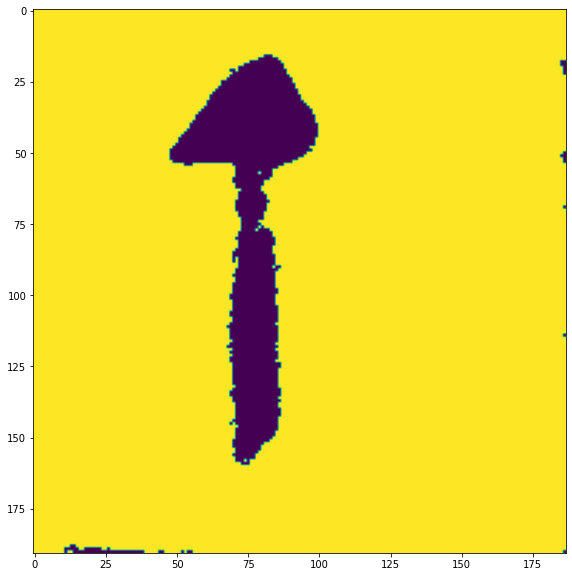

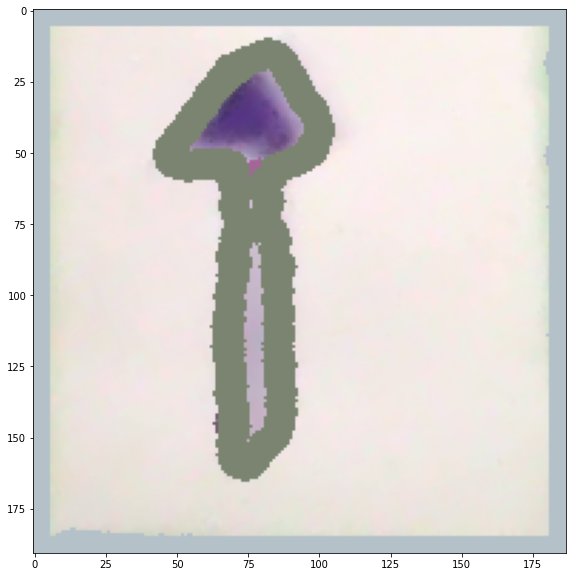

distance from camera to paper is 92.66455164204305


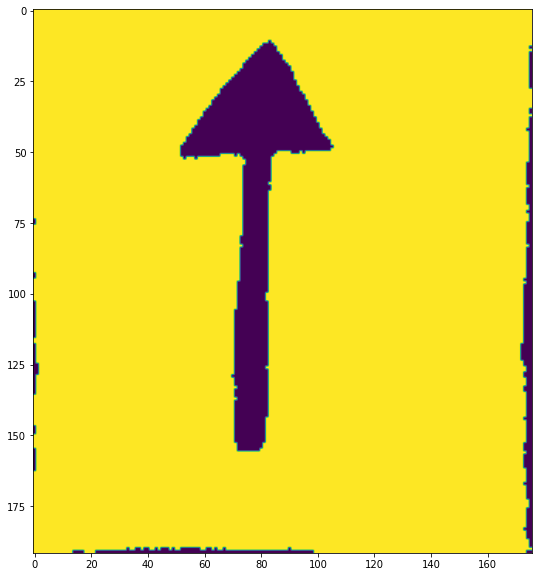

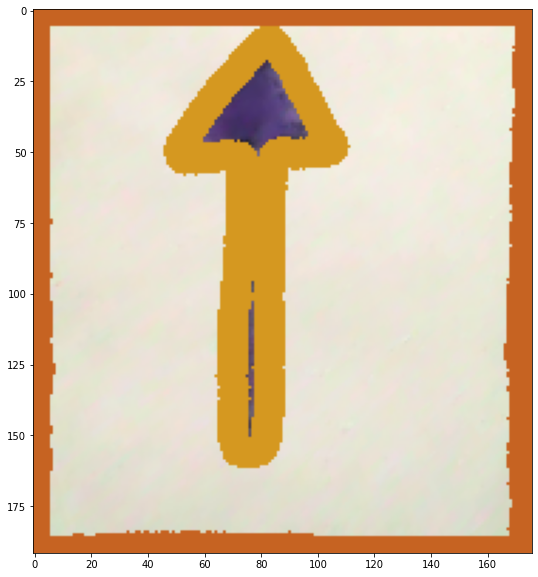

distance from camera to paper is 85.81475305837758


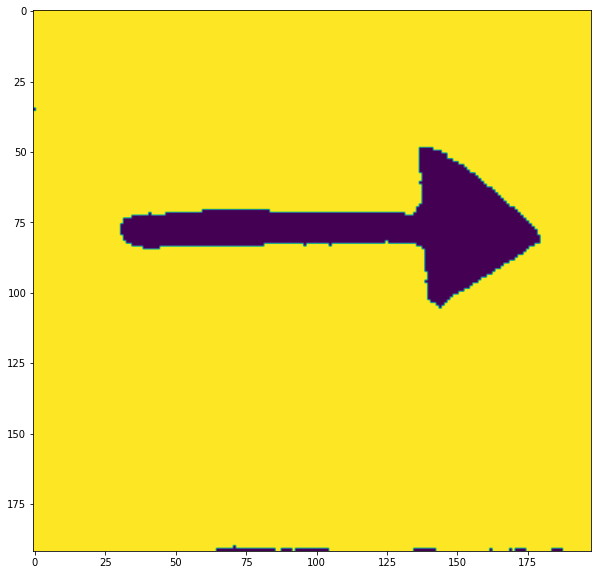

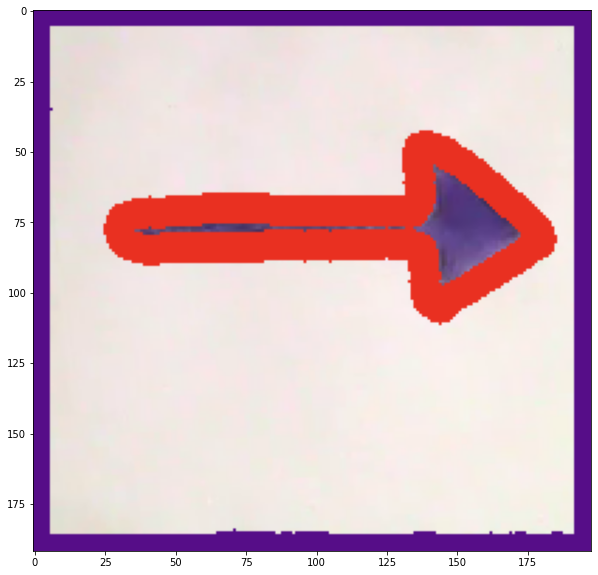

distance from camera to paper is 57.15873029607159


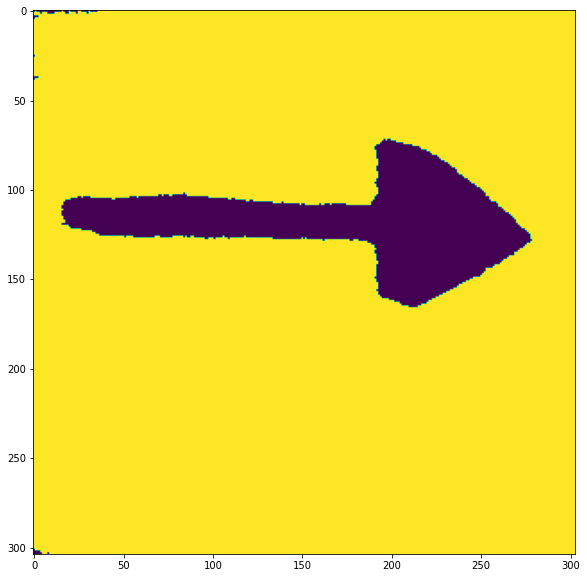

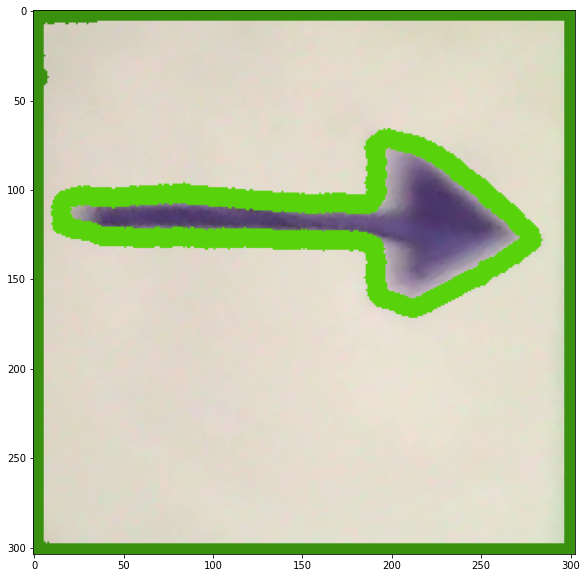

distance from camera to paper is 90.20183494255836


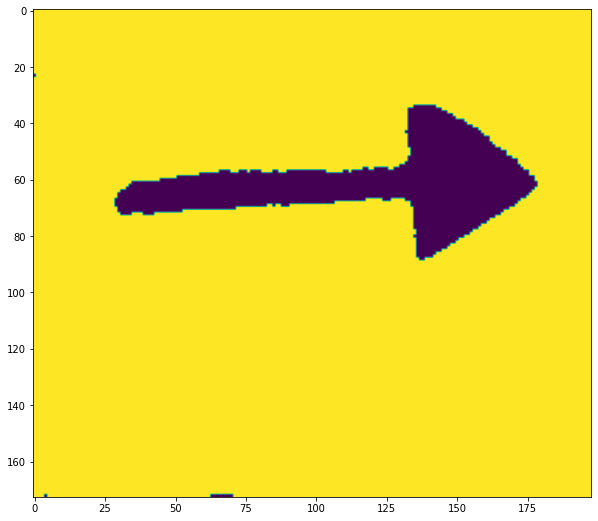

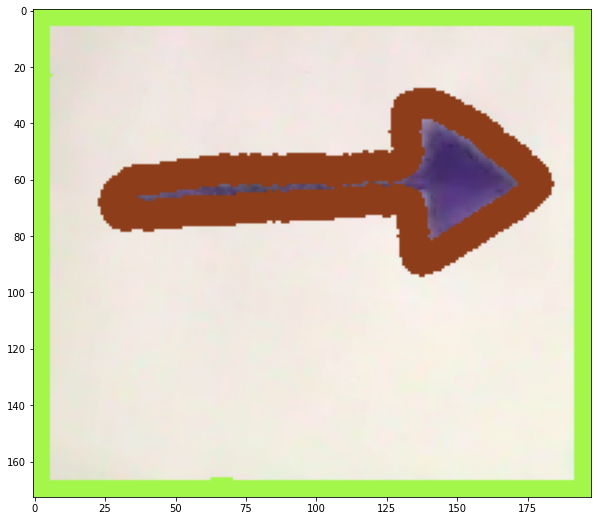

distance from camera to paper is 93.11570706519151


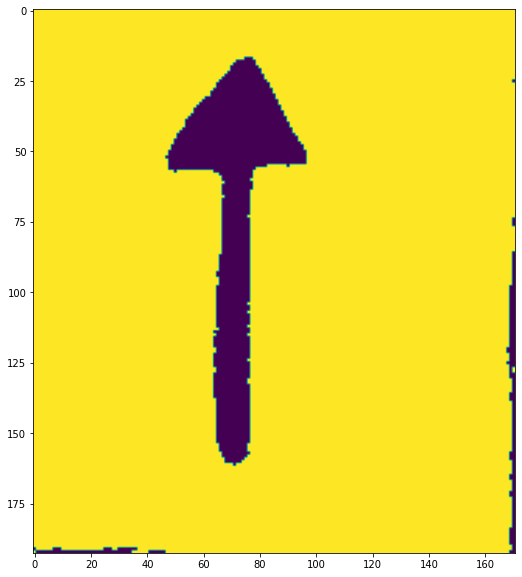

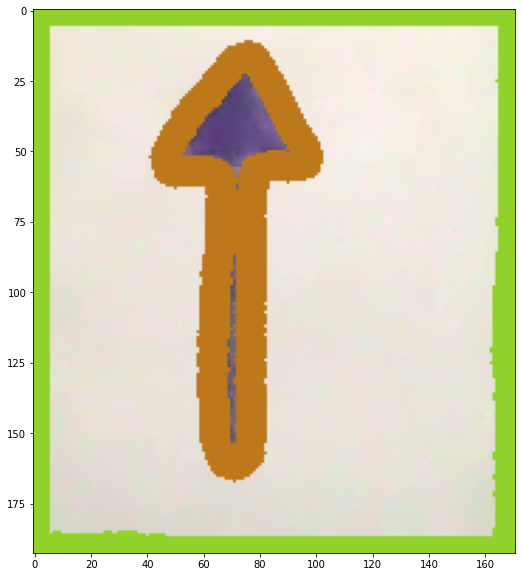

distance from camera to paper is 74.61666085686015


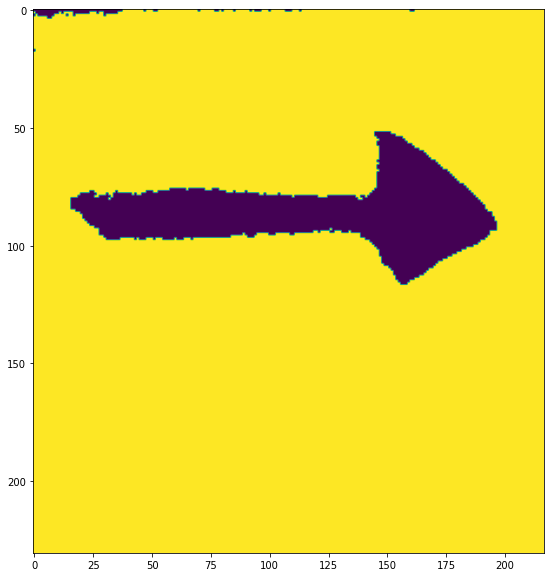

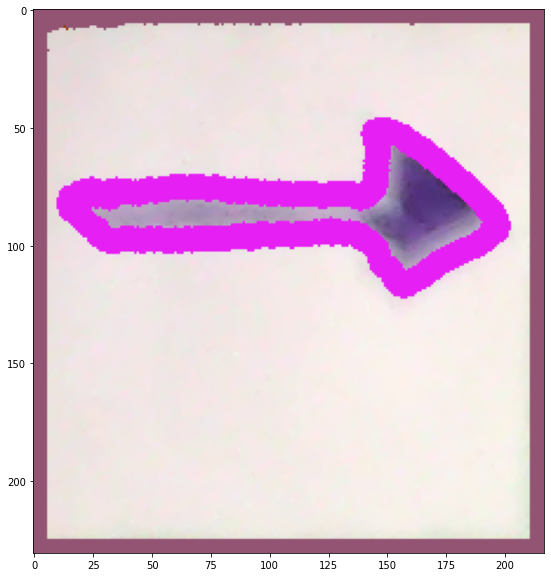

distance from camera to paper is 57.72770420829217


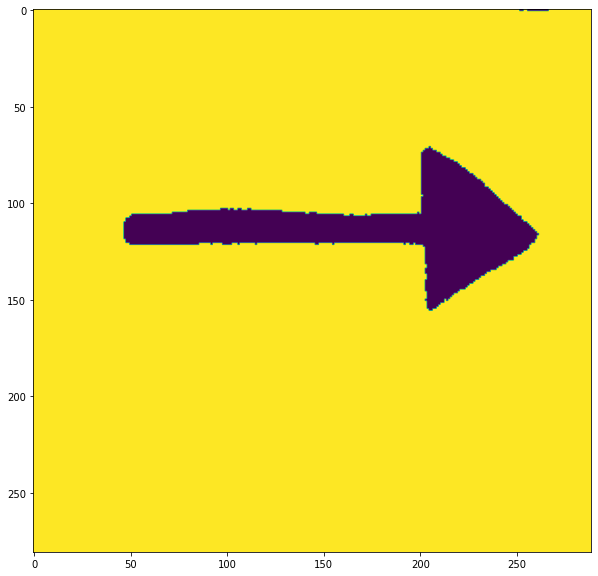

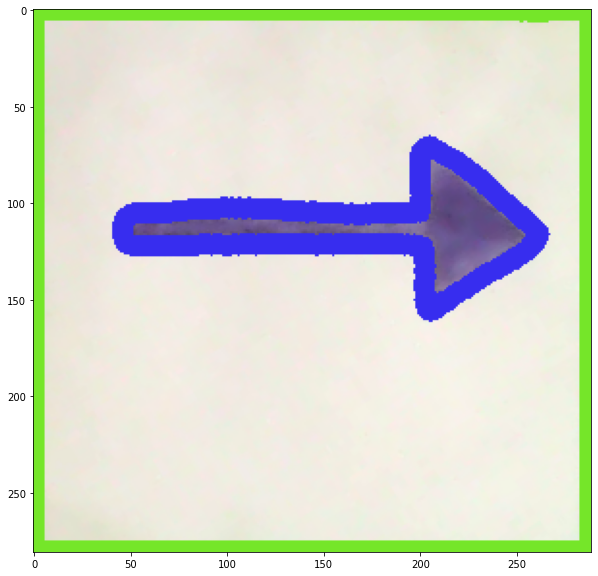

distance from camera to paper is 89.35216312176648


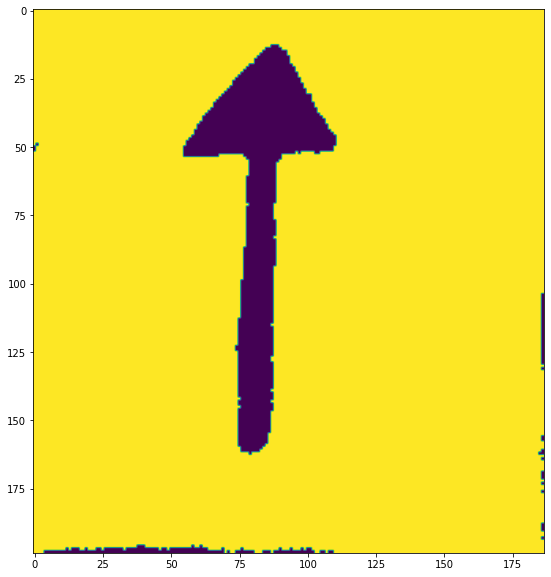

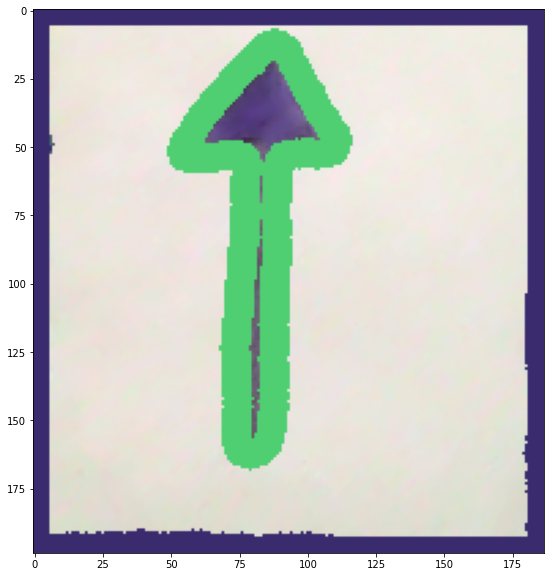

In [4]:
import glob
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
#Taking all images names from folder
images = glob.glob('../data/imgs/arrow/*.png')
plt.rcParams["figure.figsize"] = (10,10)
for fname in images:
  img = cv2.imread(fname,cv2.IMREAD_COLOR)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  contour=find_contour(img,(170,170,170),(255,255,255))
  ordered_pts=order_points(contour,show=False)
  print("distance from camera to paper is",find_distance(img,ordered_pts))
  warped=four_point_transform(img,ordered_pts,show=False)
  #warped=crop(warped,(10,190),(10,170),show=True)
  arrow_contour=find_contour(warped,(0,200,0),(255,255,255),show_mask=True,show_frame=True)